# Fractional Cover

* **Products used:** 
[fc_ls](https://explorer.digitalearth.africa/fc_ls), 
[fc_ls_summary_annual](https://explorer.digitalearth.africa/fc_ls_summary_annual),
[wofs_ls](https://explorer.digitalearth.africa/wofs_ls)


### Background

The Fractional Cover (FC) product provides estimates of the proportions of green vegetation, non-green vegetation (including deciduous trees during autumn, dry grass, etc.), and bare soils for every Landsat pixel. Fractional cover provides valuable information for a range of environmental and agricultural applications, including:

* soil erosion monitoring
* land surface process modelling
* land management practices (e.g. crop rotation, stubble management, rangeland management)
* vegetation studies
* fuel load estimation
* ecosystem modelling
* land cover mapping

The algorithm is developed by the [Joint Remote Sensing Research Program](https://www.jrsrp.org.au/) (JRSRP) and is described in Scarth et al. (2010). Field data collected across Australia have been used to calibrate and validate the unmixing model. More information on the product can be found [here](http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Seasonal+Fractional+Cover).

The DE Africa FC service has two components:

* Fractional Cover, which is estimated from each Landsat scene, providing measurements from individual days.
* Fractional Cover Annual Summary (Percentiles), which provides 10th, 50th, and 90th percentiles estimated independently for the green vegetation, non-green vegetation, and bare soil fractions observed in each calendar year (1st of January - 31st December). 

While the scened based Fractional Cover can be used to study dynamic processes, the annual summaries make it easier to analyse year to year changes. The percentiles provide robust estimates of the low, median and high proportion values observed for each cover type in a year, which can be used to characterise the land cover. Before the percentile calculation, areas of water and cloud cover, as mapped in the Water Observations from Space (WOfS) Feature Layer, are exluded.

**Reference**

Scarth, P, Roder, A and Schmidt, M 2010, 'Tracking grazing pressure and climate interaction - the role of Landsat fractional cover in time series analysis', Proceedings of the 15th Australasian Remote Sensing & Photogrammetry Conference (ARSPC), 13-17 September, Alice Springs, Australia. Alice Springs, NT.



## Description

This notebook will cover following topics:

1. Inspecting the products and measurements available in the datacube
2. Loading pre-generated FC data.
3. Cloud and water masking FC with Water Observations from Space (WOfS) Feature Layers
4. Plotting FC and the FC annual summary
5. Inspecting unmixing error outputs
6. Conducting a simple analysis workflow with FC
7. Understand and load the FC annual summary data.
8. Interpreting the annual summary percentiles

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import xarray as xr
import matplotlib.pyplot as plt
from odc.algo import xr_geomedian
from datacube.utils import masking
from fc.fractional_cover import compute_fractions

from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.datahandling import load_ard

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.

In [2]:
dc = datacube.Datacube(app='fractional_cover')

### Analysis parameters

This section defines the analysis parameters, including 

* `lat, lon, buffer`: center lat/lon and analysis window size for the area of interest
* `time_period`: time period to be investigated
* `output_crs`: projection for loading data; output resolution is not defined so different resolutions can be used for Landsat and Sentinel-2

The default location is an area along Olifants River, South Africa.

Default resolution, spatial and temporal extents are chosen to limit the time required for calculating FC from Sentinel-2 surface reflectance.

In [3]:
lat, lon = -31.5374, 18.2722 #3.9779, 41.6454

buffer_lat, buffer_lon = 0.03, 0.03

time_period = ('2017-01', '2017-10')

output_crs = 'epsg:6933'

#join lat,lon,buffer to get bounding box
lon_range = (lon - buffer_lon, lon + buffer_lon)
lat_range = (lat + buffer_lat, lat - buffer_lat)

## View the selected location

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
display_map(lon_range, lat_range)

## List products available in Digital Earth Africa

We can use datacube's `list_products` functionality to inspect the Fractional Cover products that are available. The table below shows the product names that we will use to load data.

Note that there are two separate products. The `fc_ls` product gives fractional cover percentages at daily timesteps corresponding to Landsat overpass dates, whereas the `fc_ls_summary_annual` gives the 10th, 50th, and 90th percentile values, expressed as a percentage, for each of the bare soil, photosynthetic vegetation, and non-photosynthetic vegetation fractions. We'll explore this idea further in cells below.

In [5]:
dc_measurements = dc.list_measurements()
dc_measurements.loc[['fc_ls', 'fc_ls_summary_annual']]

name  dtype    units  nodata  \
product              measurement                                        
fc_ls                bs                    bs  uint8  percent   255.0   
                     pv                    pv  uint8  percent   255.0   
                     npv                  npv  uint8  percent   255.0   
                     ue                    ue  uint8        1   255.0   
fc_ls_summary_annual pv_pc_10        pv_pc_10  uint8  percent   255.0   
                     pv_pc_50        pv_pc_50  uint8  percent   255.0   
                     pv_pc_90        pv_pc_90  uint8  percent   255.0   
                     bs_pc_10        bs_pc_10  uint8  percent   255.0   
                     bs_pc_50        bs_pc_50  uint8  percent   255.0   
                     bs_pc_90        bs_pc_90  uint8  percent   255.0   
                     npv_pc_10      npv_pc_10  uint8  percent   255.0   
                     npv_pc_50      npv_pc_50  uint8  percent   255.0   
                     npv_pc_90      npv_pc_90  uint8  percent   255.0   
                     count_valid  count_valid  int16        1   255.0   
                     qa                    qa  uint8        1   255.0   

                                      aliases  \
product              measurement                
fc_ls                bs                [bare]   
                     pv           [green_veg]   
                     npv           [dead_veg]   
                     ue                 [err]   
fc_ls_summary_annual pv_pc_10             NaN   
                     pv_pc_50             NaN   
                     pv_pc_90             NaN   
                     bs_pc_10             NaN   
                     bs_pc_50             NaN   
                     bs_pc_90             NaN   
                     npv_pc_10            NaN   
                     npv_pc_50            NaN   
                     npv_pc_90            NaN   
                     count_valid          NaN   
                     qa                   NaN   

                                                                   flags_definition  
product              measurement                                                     
fc_ls                bs                                                         NaN  
                     pv                                                         NaN  
                     npv                                                        NaN  
                     ue                                                         NaN  
fc_ls_summary_annual pv_pc_10                                                   NaN  
                     pv_pc_50                                                   NaN  
                     pv_pc_90                                                   NaN  
                     bs_pc_10                                                   NaN  
                     bs_pc_50                                                   NaN  
                     bs_pc_90                                                   NaN  
                     npv_pc_10                                                  NaN  
                     npv_pc_50                                                  NaN  
                     npv_pc_90                                                  NaN  
                     count_valid                                                NaN  
                     qa           {'qa': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'val...

## Loading pre-generated fractional cover data

FC has been calculated from Landsat Collection 2 surface reflectance, at 30 m spatial resolution. FC is generated from Landsat satellites 5, 7 and 8. Their data is combined into one product called `'fc_ls'`.

In [6]:
#generate a query object from the analysis parameters
query = {
    'time': time_period,
    'x': lon_range,
    'y': lat_range,
    'output_crs': output_crs
}

In [7]:
# load all available fc data
fc = dc.load(product='fc_ls',
             resolution=(-30, 30),
             collection_category='T1',
             **query)
print(fc)

<xarray.Dataset>
Dimensions:      (time: 46, y: 219, x: 194)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-02T08:41:12.785718 ... 2017-10...
  * y            (y) float64 -3.825e+06 -3.825e+06 ... -3.831e+06 -3.831e+06
  * x            (x) float64 1.76e+06 1.76e+06 1.76e+06 ... 1.766e+06 1.766e+06
    spatial_ref  int32 6933
Data variables:
    bs           (time, y, x) uint8 0 0 0 0 0 0 0 ... 255 255 255 255 255 255
    pv           (time, y, x) uint8 82 82 82 82 82 82 ... 255 255 255 255 255
    npv          (time, y, x) uint8 22 22 22 22 22 22 ... 255 255 255 255 255
    ue           (time, y, x) uint8 6 6 6 6 6 6 6 ... 255 255 255 255 255 255
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


## Cloud and water masking FC with Water Observations from Space (WOfS) Feature Layers

The unmixing algorithm breaks down when water or cloud is present. The `Water Observations Feature Layer` can be used to exclude these problematic pixels. For more information on bitmasking, see the [Applying WOfS bitmasking notebook](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb).

In [8]:
# load WOFLs from the same spatio-temporal extent
wofls = dc.load(product='wofs_ls',
                like=fc.geobox, #match extent of fc
                time=query['time'],
                collection_category='T1')

print(wofls)

<xarray.Dataset>
Dimensions:      (time: 46, y: 219, x: 194)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-02T08:41:12.785718 ... 2017-10...
  * y            (y) float64 -3.825e+06 -3.825e+06 ... -3.831e+06 -3.831e+06
  * x            (x) float64 1.76e+06 1.76e+06 1.76e+06 ... 1.766e+06 1.766e+06
    spatial_ref  int32 6933
Data variables:
    water        (time, y, x) uint8 64 64 64 64 64 64 64 64 ... 1 1 1 1 1 1 1 1
Attributes:
    crs:           PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 8...
    grid_mapping:  spatial_ref


### Make a clear (no-cloud) and dry (no-water) pixel mask

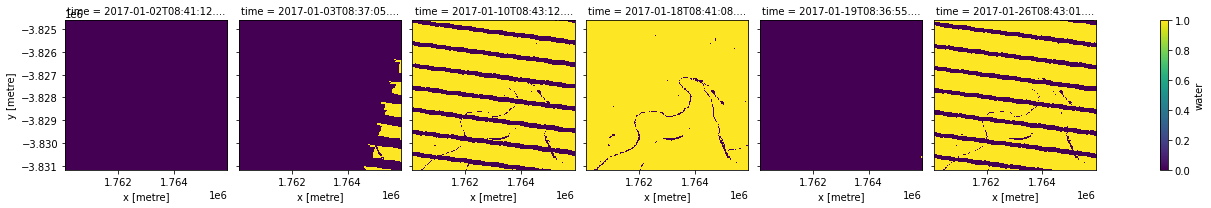

In [9]:
clear_and_dry = masking.make_mask(wofls, dry=True).water

#plot a subset of masks
clear_and_dry.isel(time=[0,1,2,3,4,5]).plot.imshow(col='time',col_wrap=6);

If we like, we can keep mostly clear scenes by calculating the number of good pixels per scene and applying a threshold

* `min_gooddata`: minimum fraction of good data required for a (FC or surface reflectance) scene to be kept

In [10]:
#set a good data fraction
min_gooddata = 0.95

#keep only the images that are at least as clear as min_gooddata
good_slice = clear_and_dry.mean(['x','y']) >= min_gooddata

Now we can apply the "clear mask" and filter to just the scenes that are mostly free of cloud and water

In [11]:
fc_clear = fc.where(clear_and_dry).isel(time=good_slice)
print(fc_clear)

<xarray.Dataset>
Dimensions:      (time: 10, y: 219, x: 194)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-18T08:41:08.825013 ... 2017-10...
  * y            (y) float64 -3.825e+06 -3.825e+06 ... -3.831e+06 -3.831e+06
  * x            (x) float64 1.76e+06 1.76e+06 1.76e+06 ... 1.766e+06 1.766e+06
    spatial_ref  int32 6933
Data variables:
    bs           (time, y, x) float64 63.0 64.0 61.0 64.0 ... 64.0 68.0 68.0
    pv           (time, y, x) float64 2.0 0.0 0.0 2.0 0.0 ... 1.0 7.0 5.0 6.0
    npv          (time, y, x) float64 34.0 35.0 38.0 33.0 ... 27.0 25.0 25.0
    ue           (time, y, x) float64 6.0 6.0 6.0 6.0 6.0 ... 5.0 6.0 7.0 7.0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


## Plotting fractional cover


<img align="right" src="../Supplementary_data/Fractional_cover/fc_legend.jpg">

We can plot each FC variable in our dataset (i.e. `['bs', 'pv', 'npv']`) using the `rgb` function. This will create a false colour view of the data where shades of green, blue and red represent varying proportions of vegetation and bare soil cover:

* Green: photosynthetic (green) vegetation (`'pv'`)
* Blue: non-photosynthetic (i.e. 'non-green') vegetation (`'npv'`)
* Red: bare soil (`'bs'`)

The chart on the right indicates how the RGB colour composition can be interpreted. 

In the area of interest used here, the resulting images show agricultural fields containing high proportions of green vegetation cover, surrounded by areas dominated by brown vegetation and bare soil. 


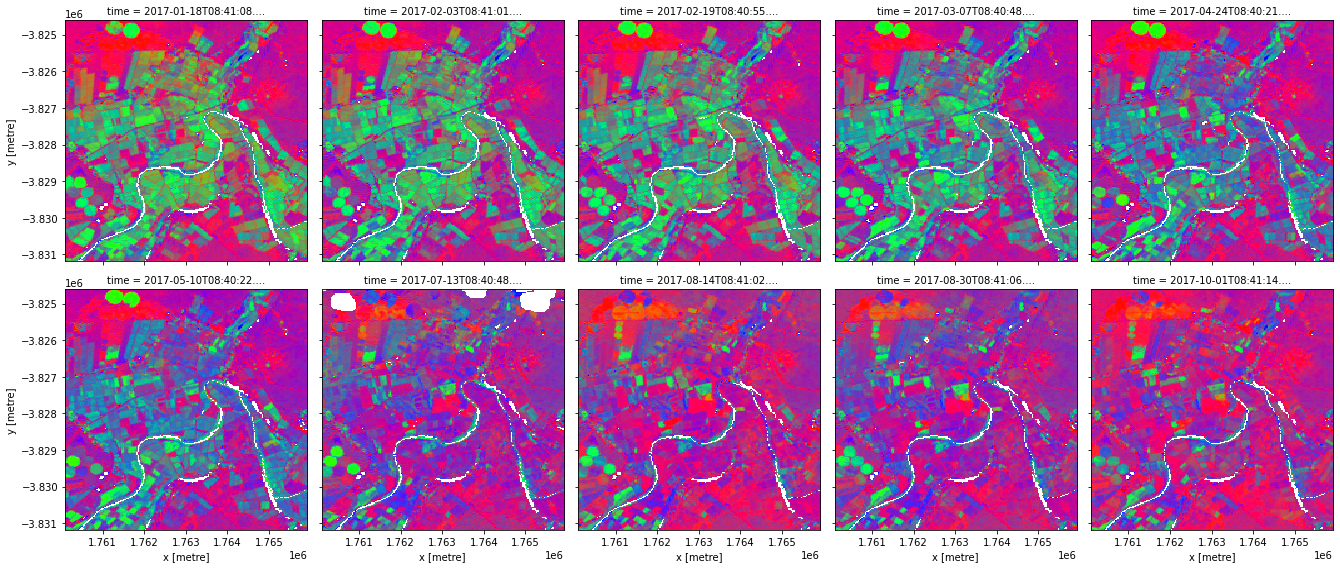

In [12]:
rgb(fc_clear,
    col='time',
    bands=['bs','pv','npv'],
    col_wrap=5,
    size=4)

## Inspecting unmixing error

Fractional cover values range between 0 and 100 %, but due to model uncertainties and the limitations of the training data, some areas may show cover values in excess of 100%. These areas can either be excluded or treated as equivalent to 100%.

We can also visualise the 'unmixing error' (ue) for each of our Fractional Cover observations. High unmixing error values (bright colours below) represent areas of higher model uncertainty (e.g. areas of water, cloud we missed masking, or soil types/colours that were not included in the model training data). This data can be useful for removing uncertain pixels from an analysis.

In this example, wet pixels associated with the river and the irrigated paddocks have relatively high unmixing errors.  Additional filtering can be done by requiring the sum of the three fractions to be close to 100 % and/or the unxming error to be small.  However, these constraints alone are not sufficient to exclude all problematic FC results. 


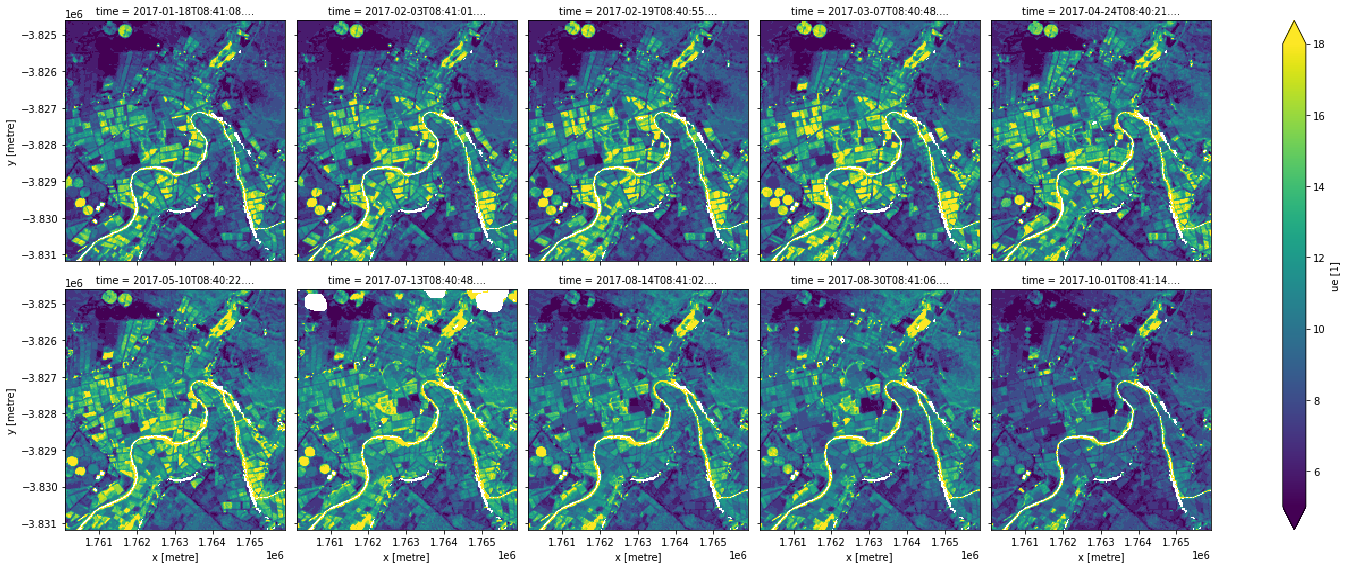

In [13]:
# Plot unmixing error using `robust=True` to drop outliers and improve contrast
fc_clear.ue.plot(col='time', robust=True, col_wrap=5, size=4);

## Example application: tracking changes in vegetation cover and bare soil over time

The following section will demonstrate a simple analysis workflow based on Fractional Cover. In this example, we will process our loaded FC data so that we can consistently track the changing proportions of green vegetation, brown vegetation and bare soil over time.

The first step is to load FC, and then mask water and clouds, and then filter to images that are mostly clear. Fortunately, we have already done this above. We will print our data `fc_clear` again to remind ourselves of the datasets contents

In [14]:
print(fc_clear)

<xarray.Dataset>
Dimensions:      (time: 10, y: 219, x: 194)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-18T08:41:08.825013 ... 2017-10...
  * y            (y) float64 -3.825e+06 -3.825e+06 ... -3.831e+06 -3.831e+06
  * x            (x) float64 1.76e+06 1.76e+06 1.76e+06 ... 1.766e+06 1.766e+06
    spatial_ref  int32 6933
Data variables:
    bs           (time, y, x) float64 63.0 64.0 61.0 64.0 ... 64.0 68.0 68.0
    pv           (time, y, x) float64 2.0 0.0 0.0 2.0 0.0 ... 1.0 7.0 5.0 6.0
    npv          (time, y, x) float64 34.0 35.0 38.0 33.0 ... 27.0 25.0 25.0
    ue           (time, y, x) float64 6.0 6.0 6.0 6.0 6.0 ... 5.0 6.0 7.0 7.0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


### Calculating average fractional cover over time

Now that our FC data has had nodata values and cloud, shadow and water pixels set to NaN, we can reliably track how average proportions of green and brown vegetation and bare soil have changed over time across our entire study area. We can then plot this as a line chart, showing that green vegetation (`pv`) has consistently decreased over time at this location, while bare soil (`bs`) has increased, and non-photosynthetic (`npv`) vegetation has been relatively stable.


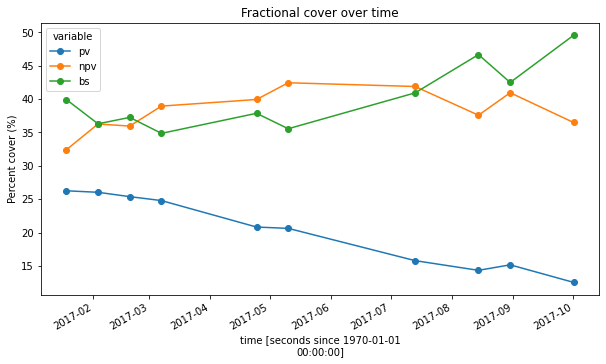

In [15]:
# Calculate average fractional cover for `bs`, `pv` and `npv` over time
fc_through_time = fc_clear[['pv', 'npv', 'bs']].mean(dim=['x', 'y'])

# Plot the changing proportions as a line graph
fc_through_time.to_array().plot.line(hue='variable', figsize=(10,5), marker='o')
plt.title('Fractional cover over time')
plt.ylabel('Percent cover (%)');

## Understanding the FC annual summary

The fractional cover annual summary product gives annual percentile values for each of the three fractions (pv, bs, npv). 

This idea is shown below where we plot a histogram of pv values for the area loaded above, with the pv % on the x-axis and density on the y-axis. We can see the distribution is positively skewed as most values are between 0% and 20%. The 10th, 50th, and 90th percentiles are plotted to demonstrate the information available in the annual summary product. In this case, the 10th percentile for pv is close to 0%, the 50th percentile is about 11% and the 90th percentile is about 47%. 

### Omit missing values from dataset

In [16]:
fc_clear = fc.where(fc!= 255)

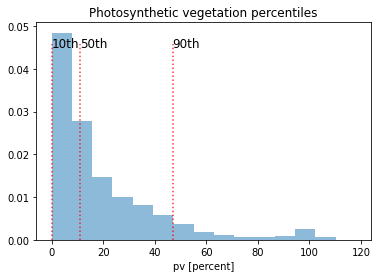

In [17]:
fig, ax = plt.subplots(figsize = (6,4))

fc_clear.pv.plot(density = True, alpha = 0.5, bins = 15)
# Calculate percentiles
quant_values = fc_clear.pv.quantile([0.1, 0.5, 0.9])

# [quantile, opacity, length]
quants = [[quant_values[0], 0.8, 0.9], [quant_values[1], 0.8, 0.9], [quant_values[2], 0.8, 0.9]]

# Plot the lines
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":", color = 'r')
    
ax.text(quant_values[0]-.1, 0.045, "10th", size = 12)
ax.text(quant_values[1]-.1, 0.045, "50th", size = 12)
ax.text(quant_values[2]-.1, 0.045, "90th", size = 12)

plt.title("Photosynthetic vegetation percentiles")
plt.show();

## Load the annual summary

The annual summary can be used to monitor changes from year to year.

In [18]:
fc_summary = dc.load(product='fc_ls_summary_annual',
                like=fc.geobox, #match extent of fc
                time=('2018','2020'))

print(fc_summary)

<xarray.Dataset>
Dimensions:      (time: 3, y: 219, x: 194)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999999 ... 2020-07...
  * y            (y) float64 -3.825e+06 -3.825e+06 ... -3.831e+06 -3.831e+06
  * x            (x) float64 1.76e+06 1.76e+06 1.76e+06 ... 1.766e+06 1.766e+06
    spatial_ref  int32 6933
Data variables:
    pv_pc_10     (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 5 10 9 8 6 6 5 5 4 8
    pv_pc_50     (time, y, x) uint8 2 3 3 2 4 2 2 3 ... 19 17 13 11 10 11 10 12
    pv_pc_90     (time, y, x) uint8 20 17 18 18 17 16 18 ... 26 19 13 17 17 17
    bs_pc_10     (time, y, x) uint8 41 43 36 33 42 44 44 ... 30 42 48 49 50 52
    bs_pc_50     (time, y, x) uint8 55 56 55 54 56 57 58 ... 38 47 54 55 54 55
    bs_pc_90     (time, y, x) uint8 63 64 63 61 63 65 65 ... 45 53 61 59 60 61
    npv_pc_10    (time, y, x) uint8 28 28 31 30 28 29 28 ... 35 33 28 24 27 24
    npv_pc_50    (time, y, x) uint8 37 39 38 39 39 39 38 ... 44 37 34 34 34 28
    npv_pc

## Plot and interpret the annual summary percentiles

For each cover type, 10th, 50th and 90th percentiles are estimated from all the clear and valid fraction measurements from a calendar year. 
As shown above, these percentiles provide estimates of the low, median and high values in a distribution that are robust against outliers. 

The example below shows the three percentiles for the green cover fraction, which can serve as proxies for the minimum, typical and maximum green cover for a given year.

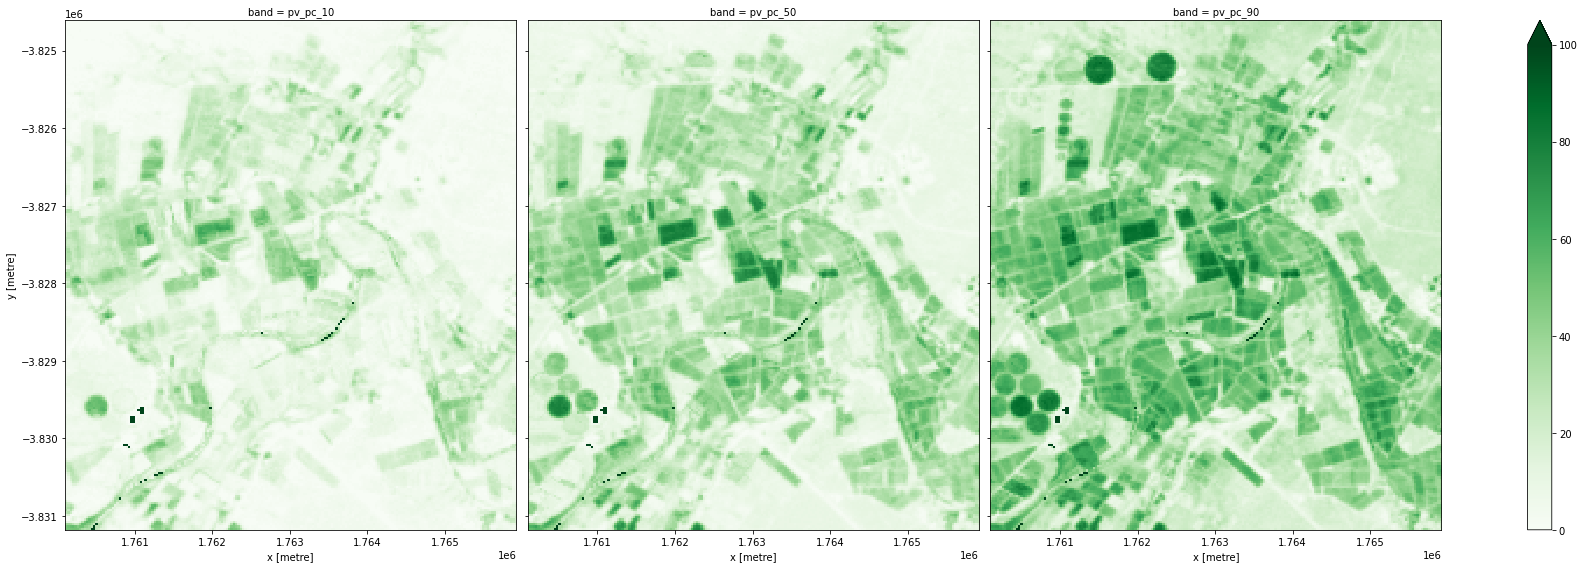

In [19]:
fc_summary.isel(time=-1)[['pv_pc_10', 'pv_pc_50', 'pv_pc_90']].to_array(dim='band').plot.imshow(col='band', cmap='Greens', vmin=0, vmax=100, size=8);

Because the percentiles are estimated independently for the three cover types, the 10th percentiles represent the low end of the measurements for the three covers, which may have been observed at different times of a year. 
Simiarly, the 90th percentiles respresent the high end of the measurements for the three covers, which may have occured at different times.
These percentile values can be used separately or combined to understand the land cover dynamics.

For example, using the 90th percentile PV as proxy for maximum green cover fraction that is observed within a year, irrigated fields are shown below to have achieved highest maximum green cover in all years.

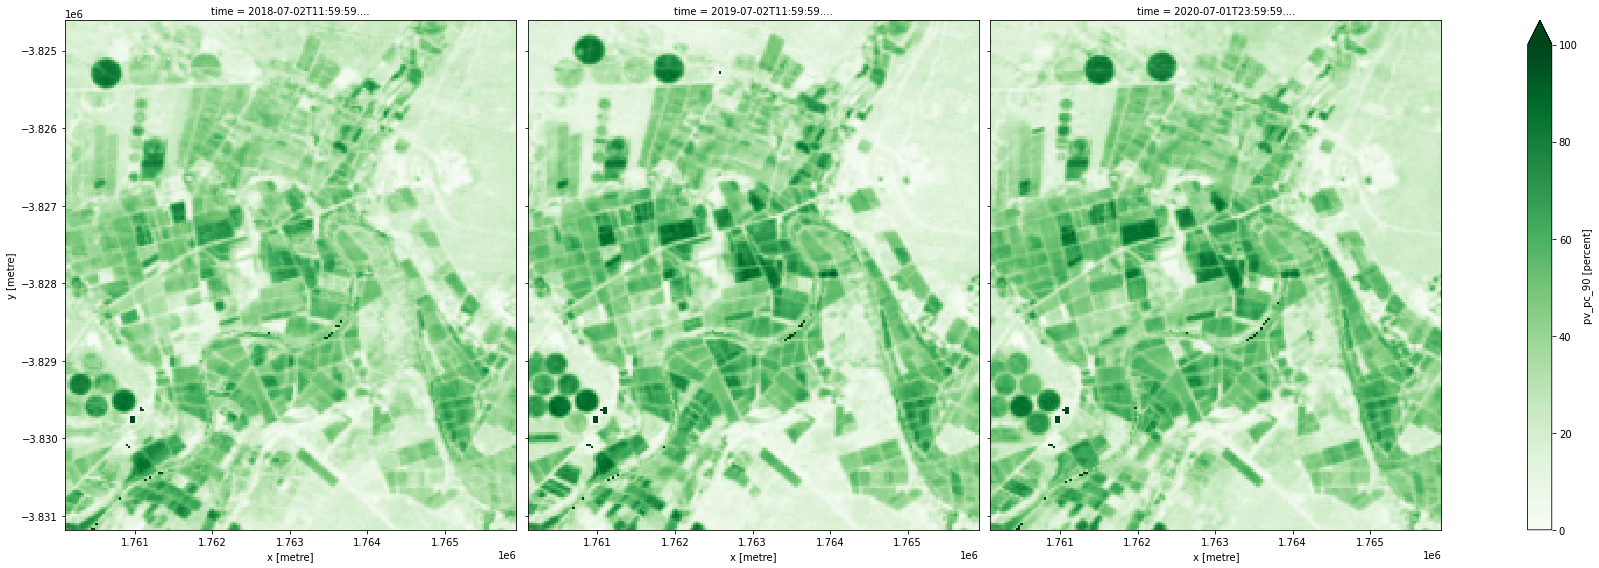

In [20]:
fc_summary['pv_pc_90'].plot.imshow(col='time', cmap='Greens', vmin=0, vmax=100, size=8);

The 10th percentile BS can be used as proxy for lowest bare soil fraction observed in a year.

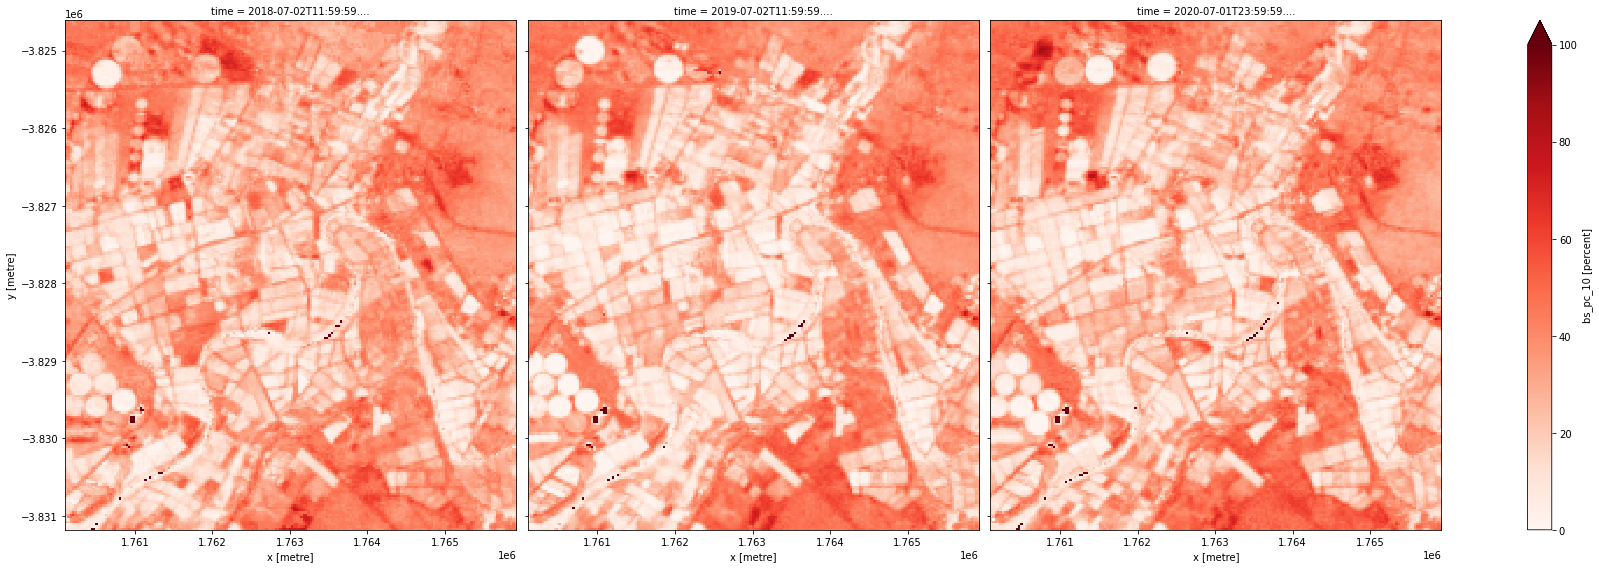

In [21]:
fc_summary['bs_pc_10'].plot.imshow(col='time', cmap='Reds', vmin=0, vmax=100, size=8);

Because at any given time, the three covers add up to 100 percent, the lowest bare soil fraction can be used to derive highest total vegetation cover.

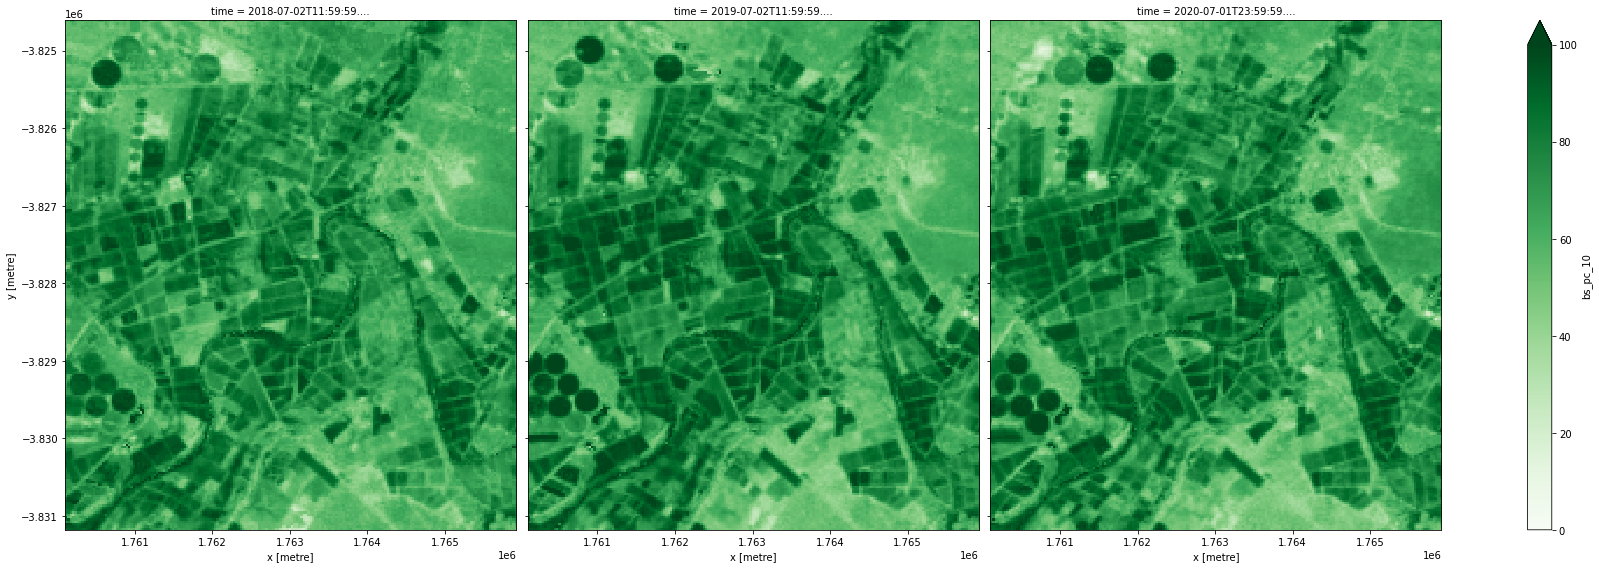

In [22]:
(100-fc_summary['bs_pc_10']).plot.imshow(col='time', cmap='Greens', vmin=0, vmax=100, size=8);

Difference between the 10th and 90th percentiles provides an estimate of the magnitude of change within a year.
In this example, greater variation is observed in the agricultural land for all covers and as specifically shown below, the most significant changes in the green cover are observed in irrigated fields.

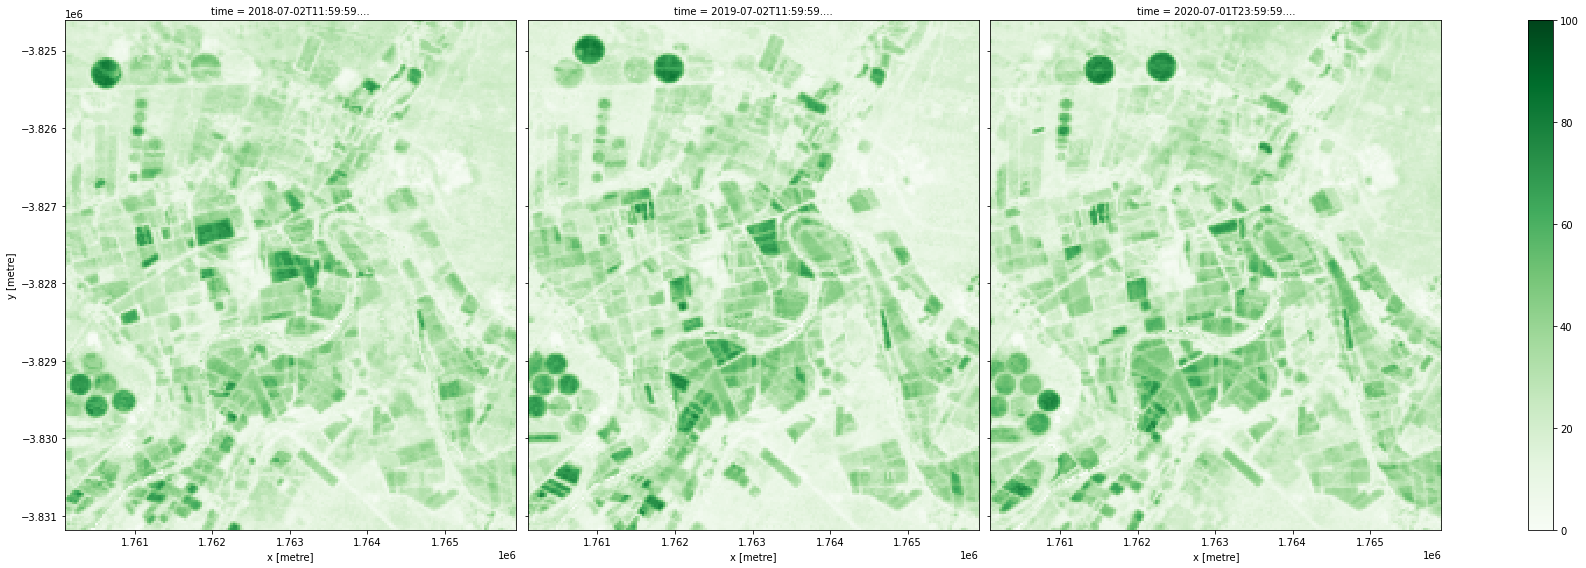

In [23]:
(fc_summary['pv_pc_90']-fc_summary['pv_pc_10']).plot.imshow(col='time', cmap='Greens', vmin=0, vmax=100, size=8);

Finally, a representative view of the landscape in a year can be obtained by combining the 50th percentiles, or the median values, for the three cover types. Changes from year to year can be visualized easily, which may be particularly useful for monitoring natural vegetation. 

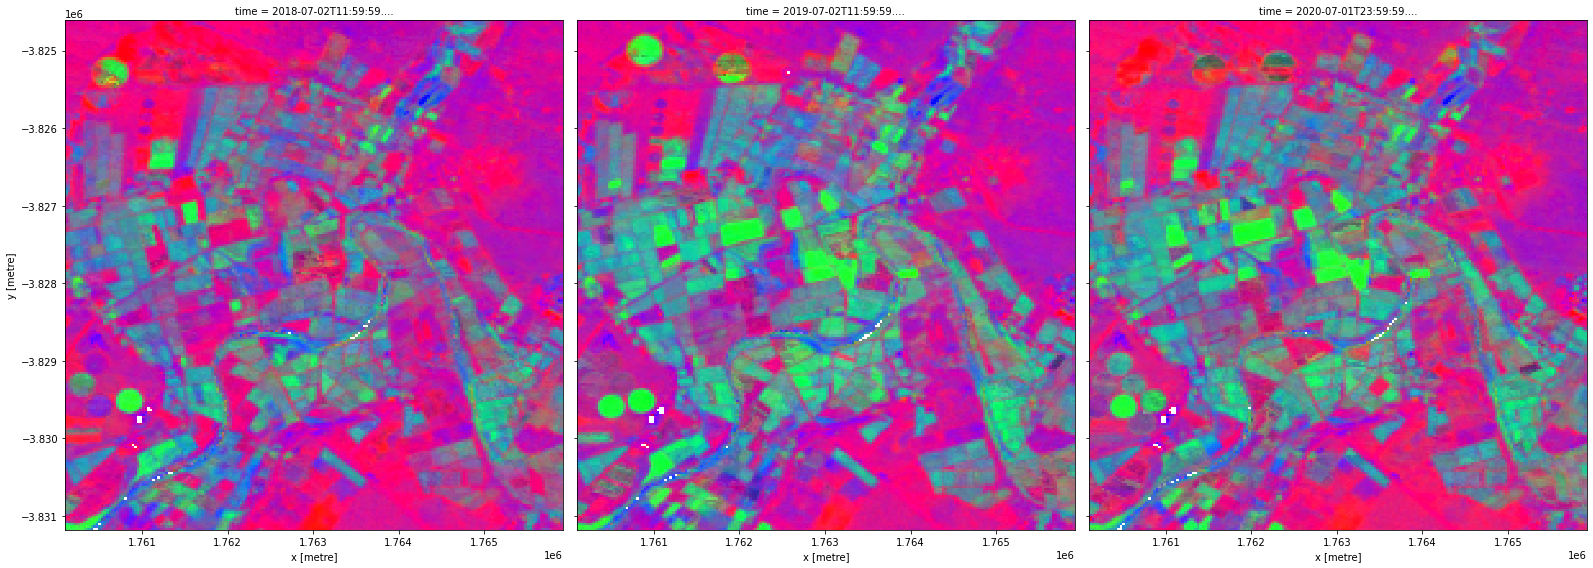

In [24]:
rgb(fc_summary,
    bands=['bs_pc_50','pv_pc_50','npv_pc_50'],
    size=8, col='time');

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to repoart an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [25]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [26]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-02-23'